# Univariate Time Series 

A Time Series is typically defined as a series of values that one or more variables take over successive time periods. For example, sales volume over a period of successive years, average temperature in a city over months etc. If the series is about only one variable, it is called Univariate Time Series. If the series lists values of more than one variables over different points of time, it is called Multivariate Time Series.

The different components of a time series are:

1) Trend- Trend is a consistent long-term upward or downward movement of the data values over a period of time. For example, increasing sales or profit over quarters.

2) Seasonal Component- Repetitive upward or downward movement from the trend that occurs within a calendar year such as seasons, quarters, months etc. One of the most popular examples is the gadgets sales spikes during festivals like Diwali, Christmas etc.

3) Cyclical Component- Fluctuation around the trend line, with time duration between repetitions of more than a year. Periodicity of cyclical fluctuations is not constant, unlike that of seasonal component. Examples are fluctuations in business metrics, due to recession, unemployment etc.

4) Noise or Irregular Component- Random uncorrelated changes that follow a normal distribution with mean value of zero and constant variance ( also called White noise ).

# Importing Libraries

In [1]:
#basic libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

#time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit

#settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (16,6)

# Read Data

The below data is from Amazon Stock Prices.

About the data: 

1) Date - in format: yy-mm-dd

2) Open - the price of the stock at market open

3) High - Highest price reached in the day

4) Low - Lowest price reached in the day

5) Close - The stock closing at the end of the Market hours

6) Adj Close - Is the closing price after adjustments for all applicable splits and dividend distributions.

7) Volume - Number of shares traded

In [2]:
data = pd.read_csv("Amazon.csv",parse_dates=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


# Data Processing

The steps involved:

1) Checking datatypes of the variables.

2) Getting month and year from date column

3) Checking null values, if any.

4) Converting Numeric Months to text

5) Adding missing dates in order to make the time series data continous in nature.

In [3]:
#checking datatypes of the variables

data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

The data is given from 1997 to 2020 but we won't be needing this much volume of data to make future predictions.

Will be using data from the year 2016 so to have accurate future predictions.

In [4]:
# data = data.loc['2016-01-01':'2020-07-01']

In [5]:
data['Date'] = data['Date'].astype('datetime64[ns]')
data.set_index('Date', inplace=True)

new_date_range = pd.date_range(start="2016-01-01", end="2020-07-01", freq="D")
data = data.reindex(new_date_range)

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0


In [7]:
data = data.reset_index().rename(columns={'index':'Date'})
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0
4,2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0


In [8]:
data["Year"] = pd.DatetimeIndex(data['Date']).year
data["Month"] = pd.DatetimeIndex(data['Date']).month

In [9]:
data['Year'].unique()

array([2016, 2017, 2018, 2019, 2020], dtype=int64)

In [10]:
conditions = [
    data['Month']==1,
    data['Month']==2,
    data['Month']==3,
    data['Month']==4,
    data['Month']==5,
    data['Month']==6,
    data['Month']==7,
    data['Month']==8,
    data['Month']==9,
    data['Month']==10,
    data['Month']==11,
    data['Month']==12
]

values = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

data['Month'] = np.select(conditions, values)

In [11]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,2016,January
1,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,2016,January
2,2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,2016,January
3,2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
4,2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0,2016,January


In [12]:
data.set_index("Date", inplace=True)

In [13]:
data.isnull().sum()

Open         512
High         512
Low          512
Close        512
Adj Close    512
Volume       512
Year           0
Month          0
dtype: int64

In [14]:
data = data.fillna(method='backfill', axis = 0)
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,Year,Month
Date,,,,,,,,
2016-01-01,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-02,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-03,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0,2016,January
2016-01-06,622.000000,639.789978,620.309998,632.650024,632.650024,5329200.0,2016,January
2016-01-07,621.799988,630.000000,605.210022,607.940002,607.940002,7074900.0,2016,January
2016-01-08,619.659973,624.140015,606.000000,607.049988,607.049988,5512900.0,2016,January
2016-01-09,612.479980,619.849976,598.570007,617.739990,617.739990,4891600.0,2016,January


# Exploratory Data Analysis

1) Exploring different attributes yearly: All the variables except Volume are following almost same pattern that is an upward trend.

2) Exploring different attributes monthly: To explore the data month-wise from the year 2016 to 2020, we plotted monthly line charts for Open, Close, High, Low from year 2016 to 2020. For a particular year, every attribute is almost following same pattern.

Text(0.5, 1.0, 'Volume')

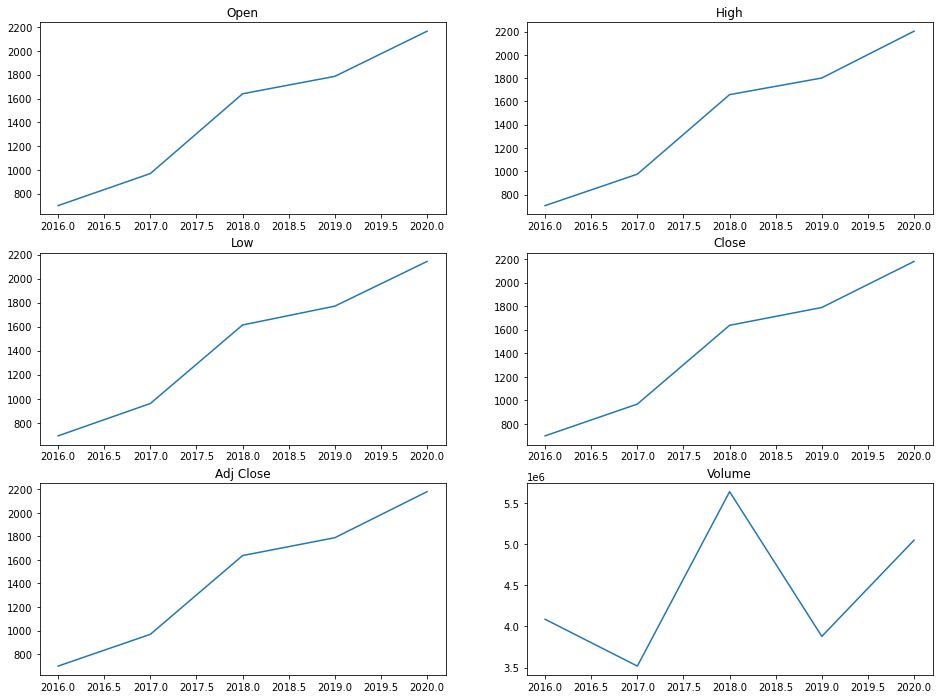

In [15]:
#Exploring Data Yearly


yearly_data = (data.groupby(['Year']).mean()).reset_index()
fig, axs = plt.subplots(3,2, figsize=(16,12))
axs[0,0].plot(yearly_data['Year'],yearly_data['Open'])
axs[0,0].set_title("Open")
axs[0,1].plot(yearly_data['Year'],yearly_data['High'])
axs[0,1].set_title("High")
axs[1,0].plot(yearly_data['Year'],yearly_data['Low'])
axs[1,0].set_title("Low")
axs[1,1].plot(yearly_data['Year'],yearly_data['Close'])
axs[1,1].set_title("Close")
axs[2,0].plot(yearly_data['Year'],yearly_data['Adj Close'])
axs[2,0].set_title("Adj Close")
axs[2,1].plot(yearly_data['Year'],yearly_data['Volume'])
axs[2,1].set_title("Volume")

A trend can be seen in all the variables after 2010, apart from Volume. The trend almost looks same for Open, Close, low and High prices. Now need to compare if the trend is upward in all the attributes in all the months or is there some change.

In [16]:
#Exploring data Monthly 

data_2016 = data[data['Year']==2016][['Open','High','Low','Close','Adj Close','Month']]
data_2016 = (data_2016.groupby(['Month']).mean()).reset_index()
data_2017 = data[data['Year']==2017][['Open','High','Low','Close','Adj Close','Month']]
data_2017 = (data_2017.groupby(['Month']).mean()).reset_index()
data_2018 = data[data['Year']==2018][['Open','High','Low','Close','Adj Close','Month']]
data_2018 = (data_2018.groupby(['Month']).mean()).reset_index()
data_2019 = data[data['Year']==2019][['Open','High','Low','Close','Adj Close','Month']]
data_2019 = (data_2019.groupby(['Month']).mean()).reset_index()
data_2020 = data[data['Year']==2020][['Open','High','Low','Close','Adj Close','Month']]
data_2020 = (data_2020.groupby(['Month']).mean()).reset_index()

In [17]:
sort_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

data_2016.index = pd.CategoricalIndex(data_2016['Month'], categories=sort_order, ordered=True)
data_2016 = data_2016.sort_index().reset_index(drop=True)

data_2017.index = pd.CategoricalIndex(data_2017['Month'], categories=sort_order, ordered=True)
data_2017 = data_2017.sort_index().reset_index(drop=True)

data_2018.index = pd.CategoricalIndex(data_2018['Month'], categories=sort_order, ordered=True)
data_2018 = data_2018.sort_index().reset_index(drop=True)

data_2019.index = pd.CategoricalIndex(data_2019['Month'], categories=sort_order, ordered=True)
data_2019 = data_2019.sort_index().reset_index(drop=True)

data_2020.index = pd.CategoricalIndex(data_2020['Month'], categories=sort_order, ordered=True)
data_2020 = data_2020.sort_index().reset_index(drop=True)

Text(0.5, 1.0, 'Close_2020')

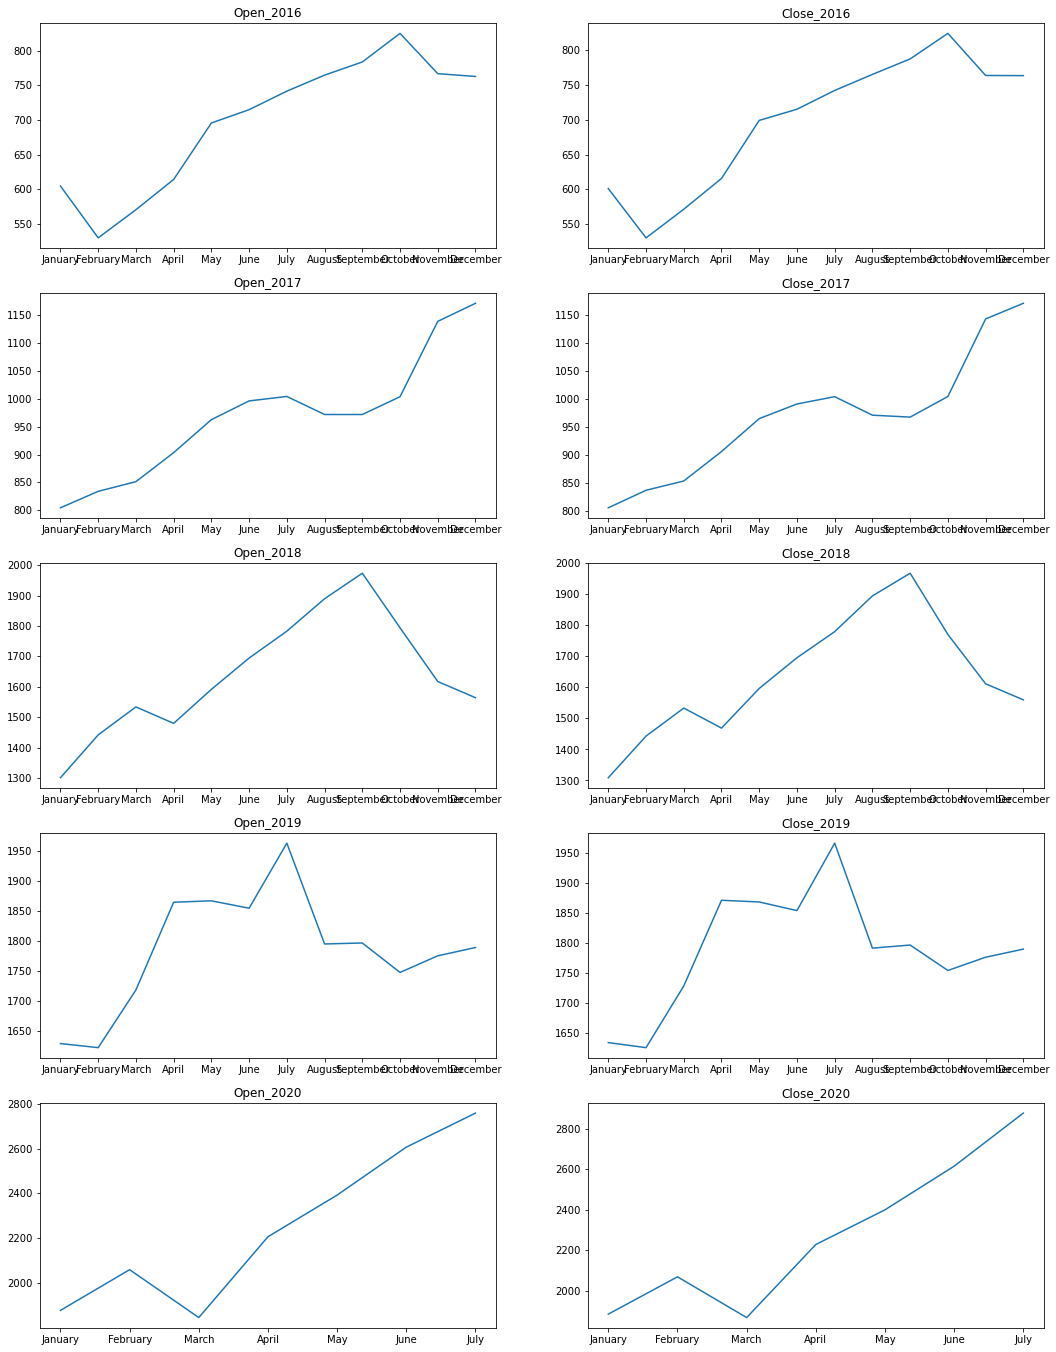

In [18]:
fig, axs = plt.subplots(5,2, figsize=(18,24))
#2016
axs[0,0].plot(data_2016['Month'],data_2016['Open'])
axs[0,0].set_title("Open_2016")
axs[0,1].plot(data_2016['Month'],data_2016['Close'])
axs[0,1].set_title("Close_2016")
#2017
axs[1,0].plot(data_2017['Month'],data_2017['Open'])
axs[1,0].set_title("Open_2017")
axs[1,1].plot(data_2017['Month'],data_2017['Close'])
axs[1,1].set_title("Close_2017")
#2018
axs[2,0].plot(data_2018['Month'],data_2018['Open'])
axs[2,0].set_title("Open_2018")
axs[2,1].plot(data_2018['Month'],data_2018['Close'])
axs[2,1].set_title("Close_2018")
#2019
axs[3,0].plot(data_2019['Month'],data_2019['Open'])
axs[3,0].set_title("Open_2019")
axs[3,1].plot(data_2019['Month'],data_2019['Close'])
axs[3,1].set_title("Close_2019")
#2020
axs[4,0].plot(data_2020['Month'],data_2020['Open'])
axs[4,0].set_title("Open_2020")
axs[4,1].plot(data_2020['Month'],data_2020['Close'])
axs[4,1].set_title("Close_2020")

Text(0.5, 1.0, 'High_2020')

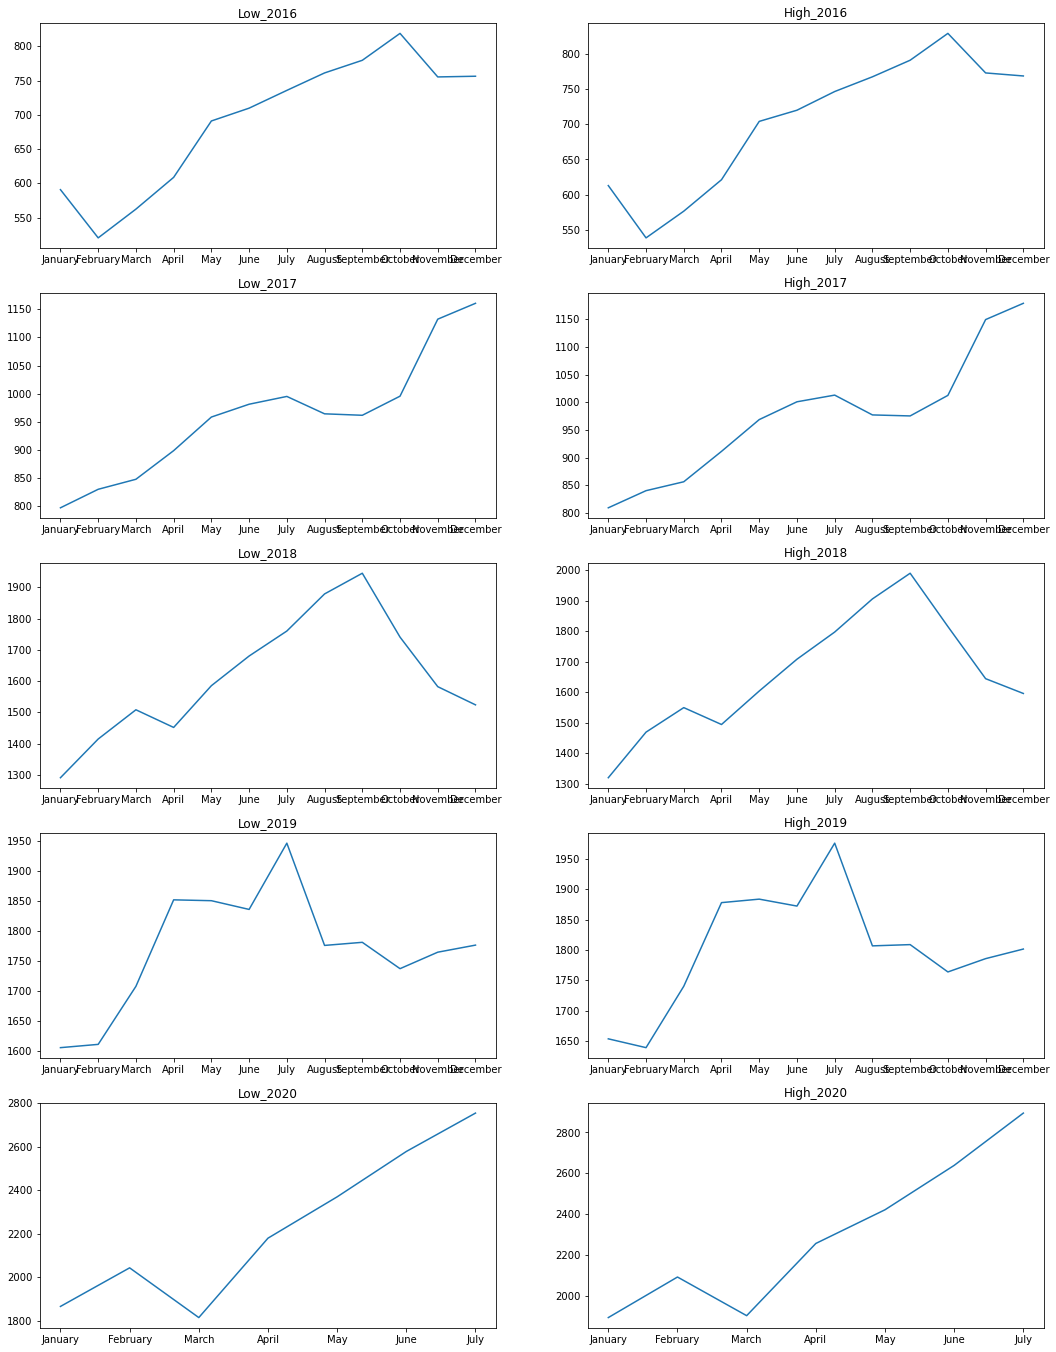

In [19]:
fig, axs = plt.subplots(5,2, figsize=(18,24))
#2016
axs[0,0].plot(data_2016['Month'],data_2016['Low'])
axs[0,0].set_title("Low_2016")
axs[0,1].plot(data_2016['Month'],data_2016['High'])
axs[0,1].set_title("High_2016")
#2017
axs[1,0].plot(data_2017['Month'],data_2017['Low'])
axs[1,0].set_title("Low_2017")
axs[1,1].plot(data_2017['Month'],data_2017['High'])
axs[1,1].set_title("High_2017")
#2018
axs[2,0].plot(data_2018['Month'],data_2018['Low'])
axs[2,0].set_title("Low_2018")
axs[2,1].plot(data_2018['Month'],data_2018['High'])
axs[2,1].set_title("High_2018")
#2019
axs[3,0].plot(data_2019['Month'],data_2019['Low'])
axs[3,0].set_title("Low_2019")
axs[3,1].plot(data_2019['Month'],data_2019['High'])
axs[3,1].set_title("High_2019")
#2020
axs[4,0].plot(data_2020['Month'],data_2020['Low'])
axs[4,0].set_title("Low_2020")
axs[4,1].plot(data_2020['Month'],data_2020['High'])
axs[4,1].set_title("High_2020")

Every year the trend is changing but it is performing almost the same for all the attributes.

In [20]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month
Date,,,,,,,,
2016-01-01,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-02,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-03,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0,2016,January


<AxesSubplot:xlabel='Date'>

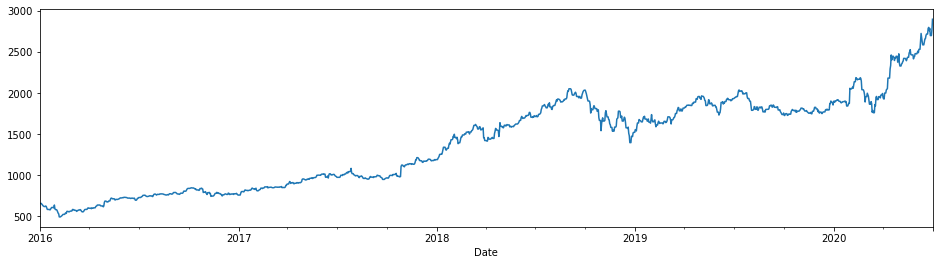

In [21]:
data['High'].plot(xlim=['2016-01-01','2020-07-01'],figsize=(16,4))

Since, the trend in the data can only be seen after or around 2016 so will be focussing on the data after 2016 only. 

In [22]:
len(data)

1644

In [23]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month
Date,,,,,,,,
2016-01-01,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-02,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-03,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0,2016,January
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0,2016,January


# Time Series Components

It has 4 components:
    
    1) Level: Mean value around which the series varies
    
    2) Trend: Increasing or decreasing behaviour of a variable with time.
    
    3) Seasonality: cyclic behaviour
    
    4) Error: It is the error in the observations added due to environmental factors.
    
 
Time Series Modelling Techniques

1) Naive Method: simple estimation technique such as predicted value is given value equal to the mean of preeceding values of time dependent variable, or previous actual values.

2) Auto Regression: predicts the values of future time periods as the function of values at previous time periods. It may not account for seasonality.

3) Arima Model:

4) Exponential Smoothing: It models the  value of a variable as an exponential weighted linear function of previous values. This statistical method can handle trend and seasonality as well.

5) LSTM and RNN

# Decomposition 

A proper time series analysis demands the data to be in a stationary way but we rarely get data with stationary characteristics. Hence, the non-stationary time series converted to a stationary series by removing its trend and seasonality. This process of removing trend and seasonality is called Time series decomposition.

Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.
The seasonal_decompose in statsmodels implements this conveniently.


As already said, we may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, a time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product of the components.

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

-> The additive model is useful when the seasonal variation is relatively constant over time.
-> The multiplicative model is useful when the seasonal variation increases over time.

In simple words, Additive model is used when the variance of the time series doesn't change over different values of the time series. On the other hand, if the variance is higher when the time series is higher then it often means we should use a multiplicative models.


An additive model is linear where changes over time are consistently made by the same amount.

A linear trend is a straight line.

A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.

A nonlinear trend is a curved line.

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

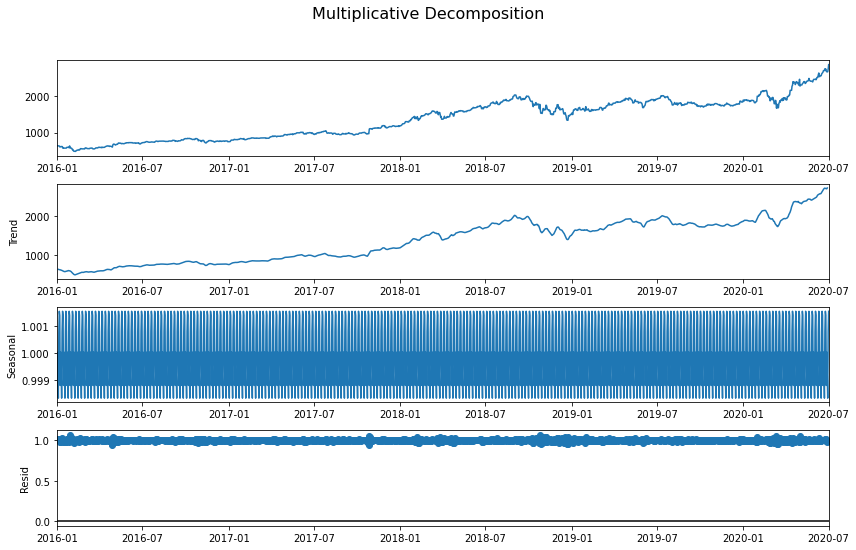

In [24]:
data_Close = pd.DataFrame(data['Close'])

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(data_Close, model='multiplicative')

# Plot
plt.rcParams.update({'figure.figsize': (12,8)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

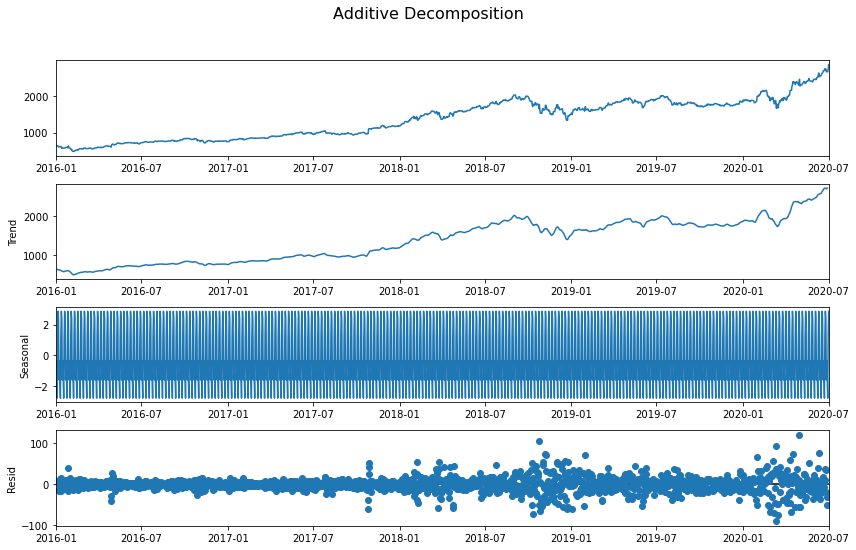

In [25]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(data_Close, model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (12,8)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


# Stationarity

Before applying any statistical model on a Time Series, the series has to be staionary, which means that, over different time periods,

a) It should have constant mean.

b) It should have constant variance or standard deviation.

c) Auto-covariance should not depend on time.

Trend & Seasonality are two reasons why a Time Series is not stationary & hence need to be corrected.


Time series with trend and/or seasonality are not stationary. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

There are other types of Stationarity as well: Strict Stationarity, Trend Stationarity and Difference Stationarity.


Time Series data needs to be stationary because:

a) If a Time Series has a particular behavior over a time interval, then there's a high probability that over a different interval, it will have same behavior, provided TS is stationary. This helps in forecasting accurately.

b) Theories & Mathematical formulas are more mature & easier to apply for as TS which is stationary.


There are 2 ways to check for Stationarity of a Time Series data:

a) Rolling Statistics - Plot the moving avg or moving standard deviation to see if it varies with time. Its a visual technique.

b) ADCF Test - Augmented Dickey–Fuller test is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a Time Series is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. THE ADCF test also gives us a p-value. Acc to the null hypothesis, lower values of p is better.

There are other tests as well that can be used to check the stationarity of the series and they are: KPSS and PP (Phillips-Perron test).

In [26]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
Year           int64
Month         object
dtype: object

<AxesSubplot:xlabel='Date'>

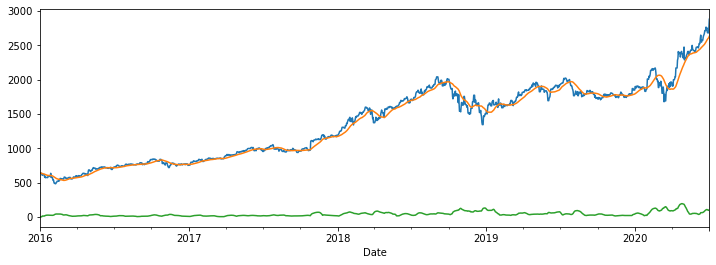

In [27]:
#Using Rolling Statistics.

data['Close'].plot(figsize=(12,4))
data['Close'].rolling(30, min_periods=2).mean().plot(figsize=(12,4))
data['Close'].rolling(30, min_periods=2).std().plot(figsize=(12,4))

In [28]:
#Using Adfuller Test

adf = adfuller(data['Close'])
print("ADF Test results")
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])

ADF Test results
ADF Statistic: 0.779360
p-value: 0.991296


H0: The time series is non-stationary.
HA: The time series is stationary.
Rule: If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

Here, p-value is 0.99, which is approx to 1 so it will greater than all significance levels. Thus, we fail to reject the null hypothesis at any significance level and the data is not stationary 

In [29]:
#checking stationarity of other variable with sig level 0.05

def adfuller_test(df, col, sig=0.05, name=''):
    adf = adfuller(df[col], autolag='AIC')    
    p_value = round(adf[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

columns = ['Open','Close','Low','High','Adj Close','Volume']
for col in columns:
    adfuller_test(data, col, name=col)

 Open : P-Value = 0.986 => Non-stationary.
 Close : P-Value = 0.991 => Non-stationary.
 Low : P-Value = 0.983 => Non-stationary.
 High : P-Value = 0.993 => Non-stationary.
 Adj Close : P-Value = 0.991 => Non-stationary.
 Volume : P-Value = 0.0 => Stationary. 


Except Volume, all variables are Non-stationary. 

# Differencing/ Transformation

We can apply some sort of transformation to make the time-series stationary. These transformation may include:

1) Differencing the Series (once or more)

2) Take the log of the series

3) Take the nth root of the series

4) Combination of the above

The most commonly used and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

Differencing: Differencing is a decomposition process through which trend and seasonality are eliminated. Here, we usually take the difference of observation with a particular instance with the previous instant.
    
If Y_t is the value at time t, then the first difference of 
        Y = Yt – Yt-1. 
    
In simpler terms, differencing the series is nothing but subtracting the next value by the current value.

If the first difference doesn’t make a series stationary, we can go for the second differencing and so on.

For example, consider the following series: [1, 5, 2, 12, 20]

First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]
Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]


Transformation: Transformation is the easiest way to remove trends from a time series by converting the data into different scales using various operations like logarithms, square roots, etc. However, it is rarely implemented over differencing due to the possibility of a loss of information.

In [30]:
data = data.drop(columns = ['Year', 'Month'])
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0
2016-01-02,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0
2016-01-03,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500.0
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600.0


In [31]:
data_differencing = data.diff().dropna()
data_differencing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2016-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2016-01-05,-9.429993,-10.809998,0.140015,-3.200012,-3.200012,-3491900.0
2016-01-06,-24.859985,-7.119995,-7.340027,-1.139954,-1.139954,-493400.0


In [32]:
for col in columns:
    adfuller_test(data_differencing, col, name=col)

 Open : P-Value = 0.0 => Stationary. 
 Close : P-Value = 0.0 => Stationary. 
 Low : P-Value = 0.0 => Stationary. 
 High : P-Value = 0.0 => Stationary. 
 Adj Close : P-Value = 0.0 => Stationary. 
 Volume : P-Value = 0.0 => Stationary. 


Since, the data is Stationary now, we don't need to go for second order differencing.

<AxesSubplot:xlabel='Date'>

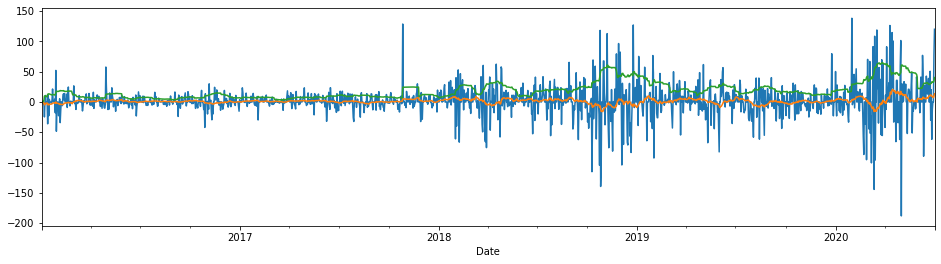

In [33]:
data_differencing['Close'].plot(figsize=(16,4))
data_differencing['Close'].rolling(30, min_periods=2).mean().plot(figsize=(16,4))
data_differencing['Close'].rolling(30, min_periods=2).std().plot(figsize=(16,4))

<AxesSubplot:xlabel='Date'>

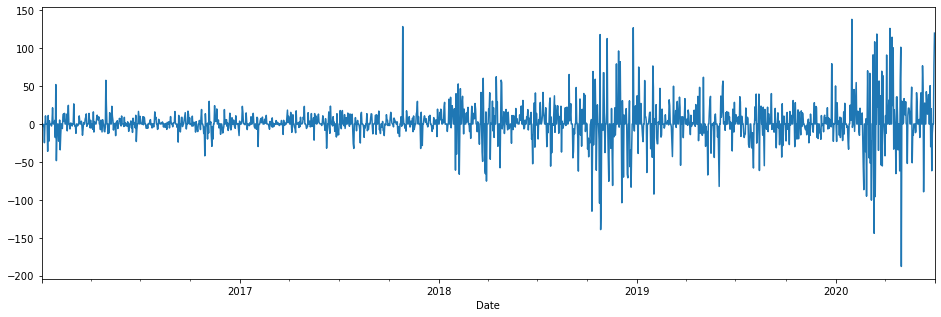

In [34]:
data_differencing['Close'].plot(figsize=(16,5))

# Train-test Split

In [35]:
uni_ts_data = pd.DataFrame(data_differencing['Close'])

train_data = uni_ts_data[:'2020-01-01']            # dataset to train
test_data = uni_ts_data['2020-01-01':]             # last X months for test  

In [36]:
train_data.head()

,Close
Date,
2016-01-02,0.000000
2016-01-03,0.000000
2016-01-04,0.000000
2016-01-05,-3.200012
2016-01-06,-1.139954


<AxesSubplot:xlabel='Date'>

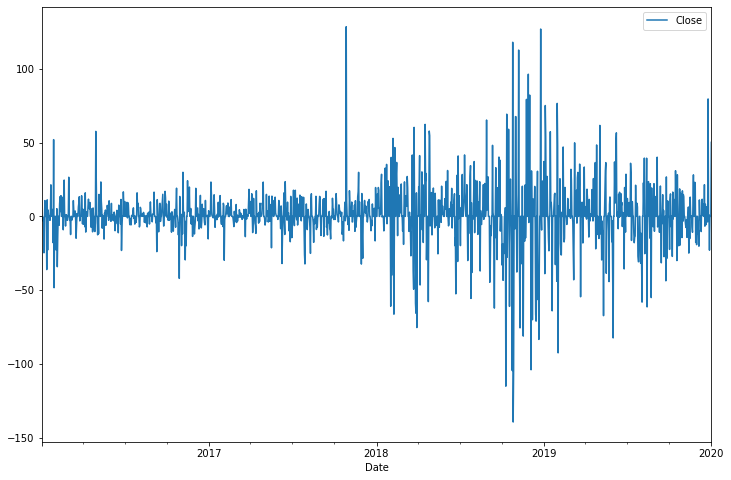

In [37]:
train_data.plot()

<AxesSubplot:xlabel='Date'>

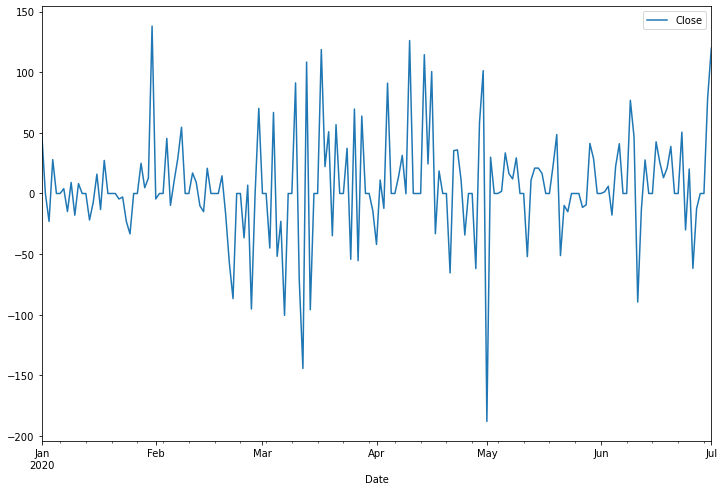

In [38]:
test_data.plot()

In [39]:
exp_data = pd.DataFrame(data['Close'])
train_data_exp = exp_data[:'2020-01-01']            # dataset to train
test_data_exp = exp_data['2020-01-01':]             # last X months for test  

In [40]:
test_data_exp.head()

,Close
Date,
2020-01-01,1898.010010
2020-01-02,1898.010010
2020-01-03,1874.969971
2020-01-04,1902.880005
2020-01-05,1902.880005


In [41]:
train_data.index

DatetimeIndex(['2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05',
               '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09',
               '2016-01-10', '2016-01-11',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', name='Date', length=1461, freq=None)

# Simple Exponential Smoothing 

In [42]:
from statsmodels.tsa.api import ExponentialSmoothing

ses = ExponentialSmoothing(train_data_exp)

alpha = 0.8
model = ses.fit(smoothing_level = alpha, optimized = False)
forecast = model.forecast(len(test_data_exp))
forecast.tail()

2020-06-28    1887.945066
2020-06-29    1887.945066
2020-06-30    1887.945066
2020-07-01    1887.945066
2020-07-02    1887.945066
Freq: D, dtype: float64

<AxesSubplot:xlabel='Date'>

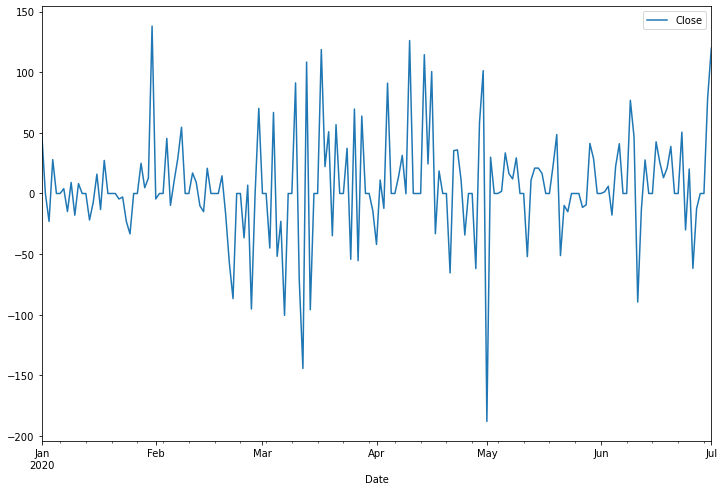

In [43]:
test_data.plot()

# Autoregression

For a stationary time series, an auto regression model sees the value of a variable at a time 't' as a linear function of values 'p' times preceeding it. 

A statistical model is said to be autoregressive if it predicts future values based on previous values.

AR(parameter) where the parameter is the number of independent variables or the count of past values considered for forecasting.

For example,

AR (1) means that it is an autoregressive process where the immediate single past value in a defined period is considered as an independent variable.

AR (2) means that it is an autoregressive process where the immediate two past values in a defined period are considered as independent variables.

AR (n) means that it is an autoregressive process where the immediate n past values in a defined period are considered as independent variables.

AR (0) is the easiest form of regression where the future value is considered as similar to the current value but this technique does not hold in growing or depreciating assets.

                             Yt = B1 (Yt-1) + B2 (Yt-2) + B3 (Yt-3) + B4 (Yt-4)

Where,

        Yt = Predicted value for next time period.

        Yt-1 = Recorded value for immediate past time period.

        Yt-2= Recorded value for immediate second past time period.

        Yt-1 = Recorded value for immediate third past time period.

        Yt-1 = Recorded value for immediate fourth past time period.

        B1 = Coefficient of auto regression for immediate past time period value.

        B2 = Coefficient of auto regression for immediate second past time period value.

        B3 = Coefficient of auto regression for immediate third past time period value.

        B4 = Coefficient of auto regression for immediate fourth past time period value.

In [44]:
ar_model = AutoReg(train_data, lags=30).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 1461
Model:                    AutoReg(30)   Log Likelihood               -6278.419
Method:               Conditional MLE   S.D. of innovations             19.463
Date:                Tue, 09 Aug 2022   AIC                          12620.838
Time:                        11:38:04   BIC                          12789.354
Sample:                    02-01-2016   HQIC                         12683.764
                         - 01-01-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0156      0.532      1.910      0.056      -0.026       2.058
Close.L1       0.0423      0.026      1.599      0.110      -0.010       0.094
Close.L2      -0.0428      0.026     -1.618      0.1

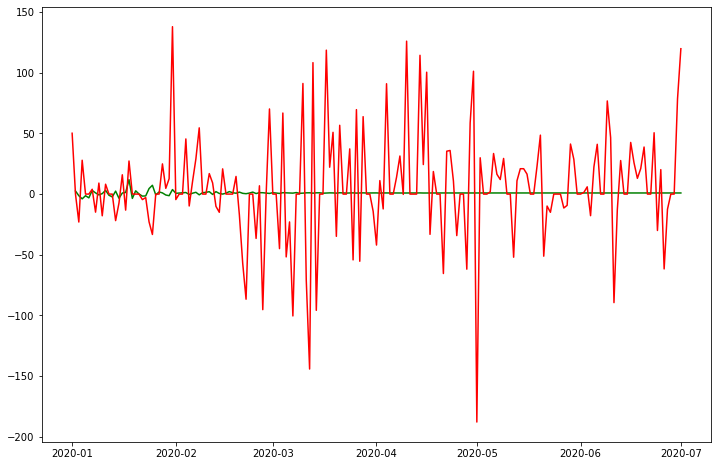

In [45]:
pred = ar_model.predict(start=len(train_data), end=(len(uni_ts_data)-1), dynamic=False)
plt.plot(pred, color='green')
plt.plot(test_data, color='red')

# Moving Average

For a stationary time series, a moving average model sees the value of a variable at time t as a linear function of  residual errors from 'q' time steps preeceding it. The residual error is calculated by comparing the value at the time 't' to moving average of the values preeceding.

Moving average is a quantified value calculated from preceding ’n’ periods to forecast the future value. It helps largely to remove noise from outlier variations still it is considered as a lagging indicator that forecasts the value much after the beginning of a trend.

                               Yt = C +Et + B1 (Et-1) + B2 (Et-2) + B3 (Et-3) +….+ B4 (Et-q)

Where,

        Et = White noise

        Et-1 = Error term at immediate previous time period.

        Et-2 = Error term at immediate second past time period.

        Et-3 = Error term at immediate third past time period.

        Et-q = Error term at immediate fourth past time period.

        B1 = Coefficient of moving average for immediate past time period value.

        B2 = Coefficient of moving average for immediate second past time period value.

        B3 = Coefficient of moving average for immediate third past time period value.

        B4 = Coefficient of moving average for immediate fourth past time period value.
        
There are various moving average techniques used in real-time use cases. The usual and easiest method is calculating the Simple moving average while there are many other advanced types of moving averages that started to become popular recently. Some of them are- Exponential moving average, Weighted moving average, Hull moving average, Triangular moving average.

Note: The major disadvantage of MA is that it will give a false signal (Type 1 or Type 2 error).

In [46]:
#Using simple moving average and Exponential weighted moving average

data['30_days_rolling'] = data['Close'].rolling(30, min_periods=2).mean()
data['EWMA30'] = data['Close'].ewm(span=30,adjust=False).mean()

<AxesSubplot:xlabel='Date'>

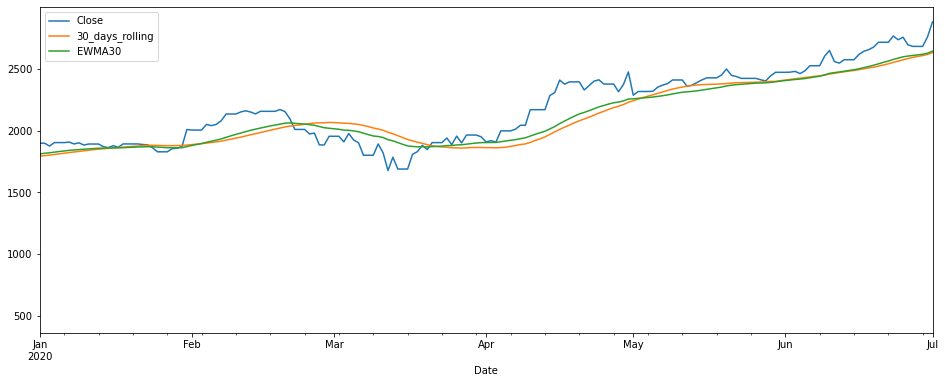

In [47]:
data[['Close','30_days_rolling','EWMA30']].plot(xlim=['2020-01-01','2020-07-01'], figsize=(16,6))

# ACF and PACF Plot

ACF: It is the correlation between the observations at the current time spot and observations at the previous time spots.

The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. A lag corresponds to a certain point in time after which we observe the first value in the time series.

To summarize, autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation.


PACF: The correlation between the observations at two time spots given that we consider both observations are correlated to the observations at the other time spots. For example, today’s stock price can be correlated to the day before yesterday, and yesterday can also be correlated to the day before yesterday. Then, PACF of yesterday is the real correlation between today and yesterday after taking out the influence of the day before yesterday.

To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.


Procedures for determining ACF and PACF:
    
1) De-trending the data

The foremost step which we need to perform is to identify whether a presence of trend is visible in the data and if so, we need to detrend the data for smooth calculations.

2) Identifying the significant terms

Use PACF to determine the significant terms used in the AR model. The numbers of terms determine the order of the model.

For example, if the PACF of yesterday’s stock price is significant and all PACF of all other days are not significant. Then yesterday’s stock price will be used to predict today’s stock price. This type of AR model is called the first-order AR model. It is represented as AR (1). A similar procedure can be used for identifying significant terms for the MA model.

3) Choosing which model to be used

We should initially calculate the significant terms for both AR and MA using PACF and ACF respectively. Then the next step is to determine which one has simpler terms that could work well for the implementation.

Suppose ACF = 6 and PACF = 8.


ACF = 6 signifies that if we are using the MA model, we should use observations of 6 previous time spots which means MA (6).

PACF = 8 signifies that if we are using the AR model, we should use observations of 8 previous time spots which means AR (8).

The minimal order out of AR and MA is chosen to reduce the complexity of the model. Here, will be choosing MA(6).

Text(0.5, 1.0, 'Stationary Data PACF')

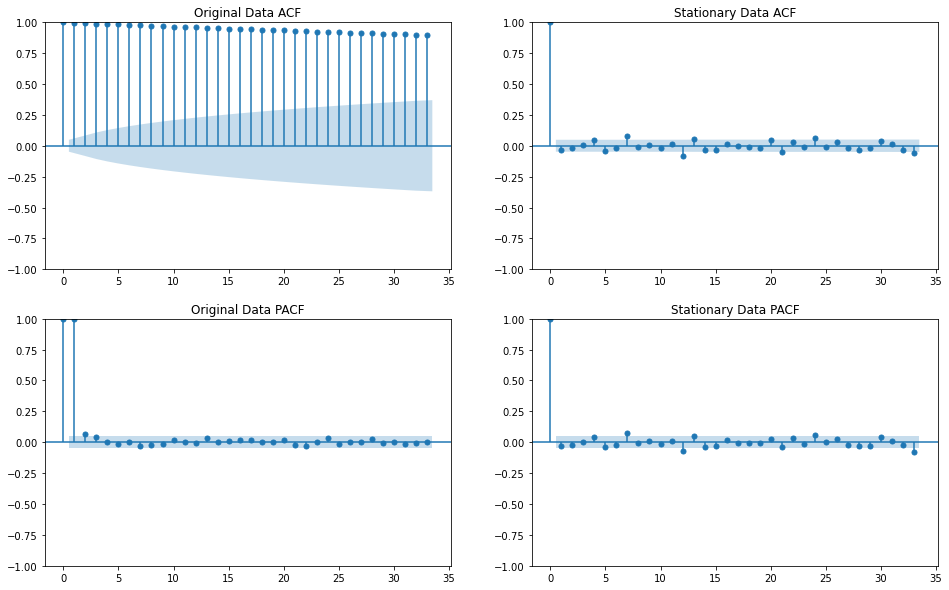

In [48]:
fig, axes = plt.subplots(2,2, figsize = (16,10))

a = plot_acf(data['Close'], ax=axes[0,0])
axes[0,0].set_title("Original Data ACF")
b = plot_acf(data_differencing['Close'], ax=axes[0,1])
axes[0,1].set_title("Stationary Data ACF")


c = plot_pacf(data['Close'], ax=axes[1,0])
axes[1,0].set_title("Original Data PACF")
d = plot_pacf(data_differencing['Close'], ax=axes[1,1])
axes[1,1].set_title("Stationary Data PACF")



# ARIMA Model

ARIMA: ARIMA Model stands for Auto-Regressive Integrated Moving Average. It is used to predict the future values of a time series using its past values and forecast errors.

It consists of Auto-Regressive, Moving Average and Integrated:

1) Auto-Regressive models predict future behavior using past behavior where there is some correlation between past and future data. The formula below represents the autoregressive model. It is a modified version of the slope formula with the target value being expressed as the sum of the intercept, the product of a coefficient and the previous output, and an error correction term.

2) Moving Average is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time. You can get it by taking different subsets of your data and finding their respective averages.

You first consider a bunch of data points and take their average. You then find the next average by removing the first value of the data and including the next value of the series.

3) Integration is the difference between present and previous observations. It is used to make the time series stationary. 

When creating an ARIMA model, we pass each component as a parameter using the following standard notations: p, d, and q. They represent the parameters that build the ARIMA model. We initialize the ARIMA model as ARIMA (p,d,q).

Here,

    p = number of significant terms in PACF for trend

    d = Order of differencing for trend

    q= number of significant terms in ACF for trend

 
For example: In above case ACF = 6, PACF = 8, if we took 1 level differencing to detrend the data, the integration factor will be 1. Then we can represent the model combining both AR and MA as ARIMA (8, 1, 6).

If we took 2 levels of differencing to detrend the data, the integration factor will be 2. Then we can represent the model combining both AR and MA as ARIMA (8, 2, 6).

# Determining p,d,q using auto_arima

In [49]:
model = auto_arima(data['Close'], start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15078.625, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15079.015, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15078.948, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15082.028, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15080.663, Time=0.77 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.139 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1644
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7537.312
Date:                Tue, 09 Aug 2022   AIC                          15078.625
Time:                        11:38:12   BIC                          15089.434
Sample:                             0   HQIC                         15082.633
                               - 1644                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3644      0.587      2.325      0.020       0.214       2.514
sigma2       565.2023      7.818     72.299      0.000     549.880     580.525
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):              7894.55
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):              11.04   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA Model

# Simple Exponential Smoothing

This method is suitable for forecasting data with no clear trend or seasonal pattern. Simple exponential smoothing works on the principle of exponential moving average and mathematically represents a time series like this-

            s(t) = ax(t) + (1-a)s(t-1)
            
Where,

        St= Forecasted value at next time spot

        Xt= Observed point at current time spot

        St-1 = Forecasted point for current time spot

        α = smoothing parameter or coefficient.
        
More weightage is given to the observation at the current time spot and less weightage is given to the forecasted point for the current time spot which is nothing but a derived value from observations recorded at previous ’n’ time spots.

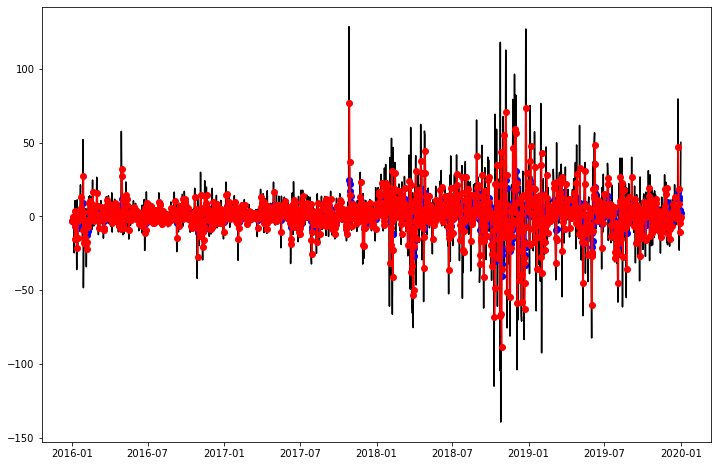

In [78]:
fit1 = SimpleExpSmoothing(train_data, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False)

fcast1 = fit1.forecast(len(test_data)).rename('alpha=0.2')

fit2 = SimpleExpSmoothing(train_data, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)

fcast2 = fit1.forecast(len(test_data)).rename('alpha=0.6')

plt.figure(figsize=(12, 8))
plt.plot(train_data, color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
#(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
#(line2,) = plt.plot(fcast2, marker="o", color="red")
#plt.legend([line1, line2], [fcast1.name, fcast2.name])

# Double exponential smoothing or Holt linear method

This is a second-order exponential smoothing technique that is used when we have an observable trend in the data. The basic idea behind this technique is to introduce a new term to an exponential smoothing formula that takes care of the possibility of a time series that potentially shows some trend.

# Prophet Model

Prophet decomposes the time series into components of trend gt, seasonality st, holidays ht.

        yt = gt + st + ht + et
        
        where, et is the error term

In [63]:
from fbprophet import Prophet 

prophet_df = train_data.copy()
prophet_df.reset_index(inplace=True)

prophet_df.rename(columns = {'Date':'ds','Close':'y'}, inplace=True)

model = Prophet()

model.fit(prophet_df)

future_dates = pd.DataFrame(test_data.reset_index()['Date'])
future_dates.columns = ['ds']

forecast = model.predict(future_dates)

print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2020-01-01  6.704993  -17.004906   30.929589
1 2020-01-02  5.770564  -21.151304   30.110529
2 2020-01-03  2.454730  -24.416025   26.891413
3 2020-01-04  7.174523  -17.241839   32.092438
4 2020-01-05  5.857456  -17.322035   30.114224


In [69]:
from sklearn.metrics import mean_absolute_error

y_true  = test_data['Close'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print("MAE: ", mae)

MAE:  27.719832840215208


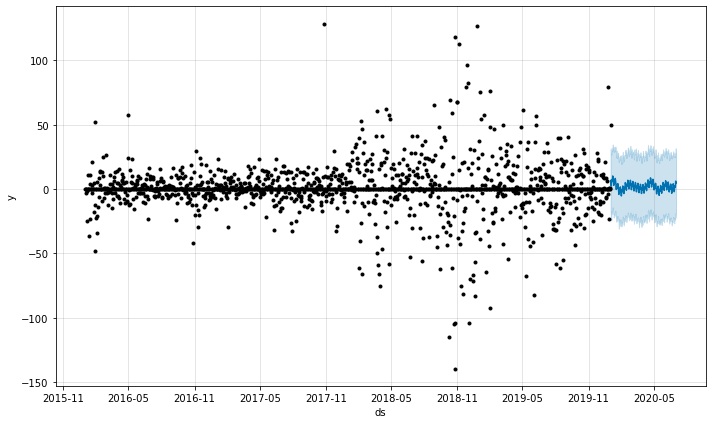

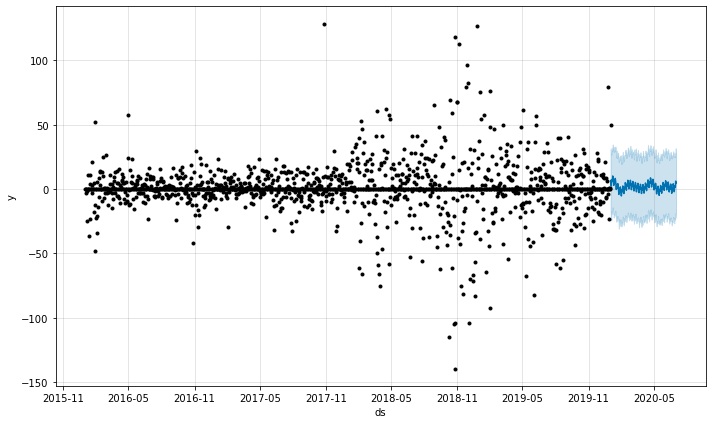

In [70]:
model.plot(forecast)

# Variations of ARIMA

ARIMA model cannot handle seasonal data or multivariate time series data and hence, new models were introduced to include these features. 

Vector Auto Regression: : generalized version of auto regression for multivariate stationary time series. Characterized by 'p' parameter.

Vector Moving Average: generalized version of moving average model for multivariate stationary time series. Characterized by 'q' parameter.

Vector Auto Regression Moving Average (VARMA): 

VARMA with Exogenous Variables (VARMAX): extension of Varma model where extra variables called covariates are used to model the primary varaibales we are intereseted it.

SARIMA (Seasonal Auto Regression Integrated Moving Average): divides the data into its seasonal and non-seasonal components and models them in a similar fashion. 

SARIMAX;

FARIMA